In [1]:
import nibabel as nb
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import os
from os.path import join
from glob import glob as glob
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from scipy import stats
import matplotlib.gridspec as gridspec
from matplotlib import ticker
import matplotlib

#%pylab

In [2]:
source_dir = '/data/neuralabc/source/MPI_CBS/MPM_DTI/source/'
seg_dir = '/data/neuralabc/source/MPI_CBS/MPM_DTI/processing/segmentations_MTSat_SPM/'
out_dir = '/data/neuralabc/carfra/QuantMetComp/processing/MPM/MPM_correlations/'

all_dirs = glob(source_dir+'*')
sub_ids = [os.path.basename(x) for x in all_dirs]
name = ['FA','MD','MTsat','PDsat','R1','$R2^*$']  #hard-coded, but I know what they are!

In [3]:
def get_sub_data(in_dir, sub_id):
    """
    Loads an individual subject's data for all modalities
    
    - in_dir {str} : sdsdsds
    """
    
    img1 = nb.load(join(in_dir,'{}_FA_reg.nii.gz'.format(sub_id)))
    img2 = nb.load(join(in_dir,'{}_MD_reg.nii.gz'.format(sub_id)))
    img3 = nb.load(join(in_dir,'{}_MTsat.nii.gz'.format(sub_id)))
    img4 = nb.load(join(in_dir,'{}_PDsat.nii.gz'.format(sub_id)))
    img5 = nb.load(join(in_dir,'{}_R1.nii.gz'.format(sub_id)))
    img6 = nb.load(join(in_dir,'{}_R2s_OLS.nii.gz'.format(sub_id)))
    
    d1 = img1.get_data()
    d2 = img2.get_data()
    d3 = img3.get_data()
    d4 = img4.get_data()
    d5 = img5.get_data()
    d6 = img6.get_data()
        
#     d = [d1,d2,d3,d4,d5,d6]
#     m = [mk>0 for mk in d]
#     mask = np.ones_like(m[0])
#     for iii in m:
#         mask = mask*iii

    d = np.stack((d1,d2,d3,d4,d5,d6),axis=3)
    mask = np.prod(d>0,axis=3).astype(bool)
    
    return {'data':d,'mask':mask,'img':img1}


# Applying on both GM and WM (most info here)

In [49]:
max_val = [None, 0.0015, 5, None, None, 40] # max value for plotting of metrics (order is FA, MD, MT, PD, R1, R2*)
name_plt = name.copy()
name_plt[-1] = 'R2$^*$'

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


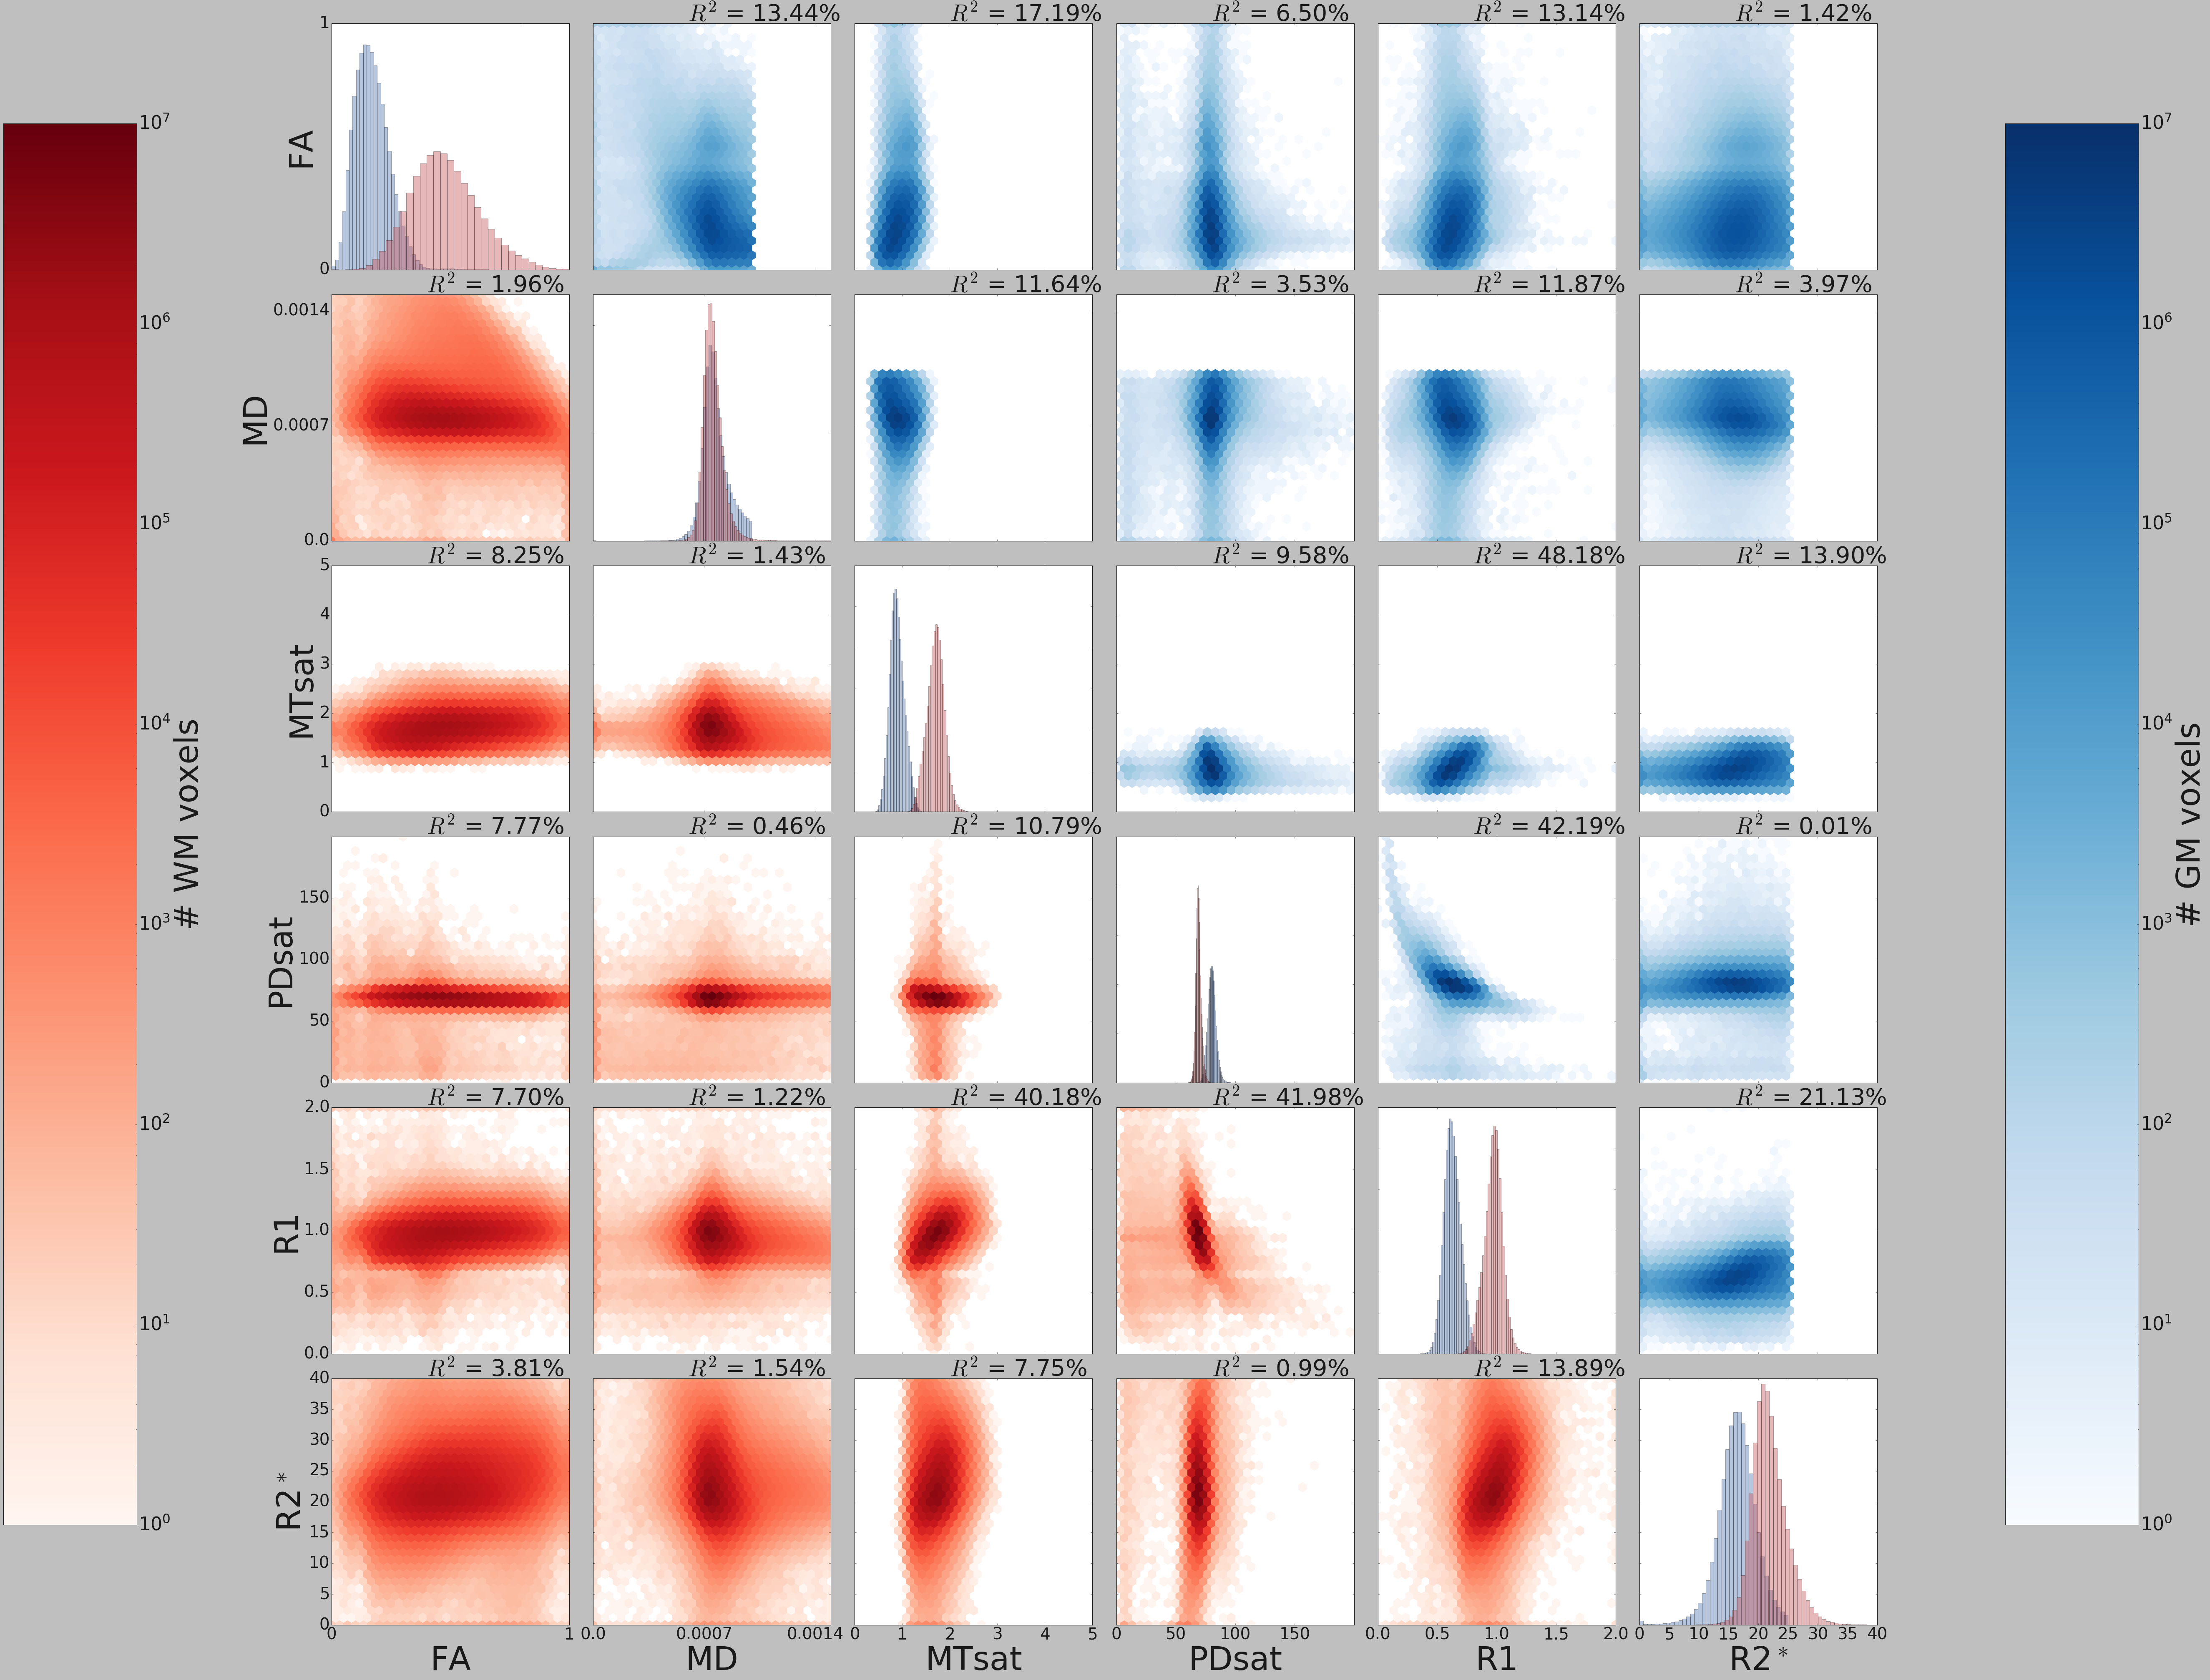

In [50]:
#edit figure from existing data
#no storage of r^2 yet, see cell above
matplotlib.style.use('classic')
out_path = '/data/neuralabc/carfra/QuantMetComp/processing/MPM/MPM_correlations/GMmasked_vs_WM2'
    
df_all_cort = pd.read_csv(join(out_path,'GM.csv'), index_col=0)
df_all_scort = pd.read_csv(join(out_path,'WM.csv'), index_col=0)
for ii in name:
    df_all_cort[ii][df_all_cort[ii]<0] = 0
    df_all_scort[ii][df_all_scort[ii]<0] = 0


fig = plt.figure(figsize=(80,60))
gs = gridspec.GridSpec(nrows=6, 
                       ncols=8, 
                       figure=fig, 
                       width_ratios= [1, 1, 1, 1, 1, 1, 1, 1],
                       height_ratios=[1, 1, 1, 1, 1, 1],
                       wspace=0.1,
                       hspace=0.1)
#     ax1 = fig.add_subplot(gs[:, 0])
#     ax2 = fig.add_subplot(gs[:, -1]) 


for xx in range(6):
    for yy in range(6):
        if max_val[xx] != None:
            max_x = max_val[xx]
        else:
            max_x = max(df_all_cort.max()[df_all_cort.columns[xx]],df_all_scort.max()[df_all_cort.columns[xx]])
        if max_val[yy] != None:
            max_y = max_val[yy]
        else:
            max_y = max(df_all_cort.max()[df_all_cort.columns[yy]],df_all_scort.max()[df_all_cort.columns[yy]]) 
        
        if xx == yy:
            ax = fig.add_subplot(gs[yy, xx+1])
            cort_bins = (df_all_cort[df_all_cort.columns[xx]].max()-df_all_cort[df_all_cort.columns[xx]].min()) / (8*df_all_cort[df_all_cort.columns[xx]].std())*40
            scort_bins = (df_all_scort[df_all_cort.columns[xx]].max()-df_all_scort[df_all_cort.columns[xx]].min()) / (8*df_all_scort[df_all_cort.columns[xx]].std())*40
            sns.distplot(df_all_cort[df_all_cort.columns[xx]], bins=int(cort_bins), color="b", kde=False, norm_hist =True)
            sns.distplot(df_all_scort[df_all_cort.columns[xx]], bins=int(scort_bins), color="r", kde=False, norm_hist =True)
            if xx == 0:
            #    ax.set_yticklabels([0,0.25,0.5,0.75,1])
                ax.set_ylim([0,ax.get_yticks()[-1]])
                ax.set_yticks(np.arange(0, ax.get_yticks()[-1]+1, ax.get_yticks()[-1]/5))
                ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
            plt.xlim(0,max_x)

        elif xx>yy:
            ax = fig.add_subplot(gs[yy, xx+1])
            hba = plt.hexbin(df_all_cort[df_all_cort.columns[xx]], 
                            df_all_cort[df_all_cort.columns[yy]], 
                            cmap='Blues',gridsize = 30,mincnt = 1,
                            bins='log',vmax = 10**7, 
                            extent=[0,max_x,
                                    0,max_y])
            r, p = stats.pearsonr(df_all_cort[df_all_cort.columns[xx]], df_all_cort[df_all_cort.columns[yy]])
            ax.annotate("$R^2$ = {:.2f}%".format((r**2)*100),
                        xy=(.4, 1.01), xycoords=ax.transAxes, fontsize = 50)
            axx = fig.gca
#                 cb = plt.colorbar(hb)
#                 cb.set_label('log10(N)')


        elif xx<yy:
            ax = fig.add_subplot(gs[yy, xx+1])
            hbb = plt.hexbin(df_all_scort[df_all_cort.columns[xx]], 
                            df_all_scort[df_all_cort.columns[yy]], 
                            cmap='Reds',gridsize = 30,mincnt = 1,
                            bins='log',vmax = 10**7, 
                            extent=[0,max_x,
                                    0,max_y])
            r, p = stats.pearsonr(df_all_scort[df_all_cort.columns[xx]], df_all_scort[df_all_cort.columns[yy]])
            ax.annotate("$R^2$ = {:.2f}%".format((r**2)*100),
                        xy=(.4, 1.01), xycoords=ax.transAxes, fontsize = 50)
            axxx = fig.gca
#                 cb = plt.colorbar(hb)
#                 cb.set_label('log10(N)')


        plt.tick_params(axis='both', which='major', labelsize=35)
        if (xx==1):
            ax.set_xticks(np.arange(0, ax.get_xticks()[-2]+0.000001, ax.get_xticks()[-2]/2))
            labels = ax.get_xticks()
            labels[0] = 0
            ax.set_xticklabels(labels)
        if (yy==1):
            ax.set_yticks(np.arange(0, ax.get_yticks()[-2]+0.000001, ax.get_yticks()[-2]/2))
            labels = ax.get_yticks()
            labels[0] = 0
            ax.set_yticklabels(labels)
        if (xx==0):
            ax.set_xticks(np.array([0,ax.get_xticks()[-2]]))
            ax.set_xticklabels(np.array([0,1]))
        if (yy==0):
            ax.set_yticks(np.array([0,ax.get_yticks()[-1]]))
            ax.set_yticklabels(np.array([0,1]))
        #labels = ax.get_xticks()
        #labels[0] = "0"
        #ax.set_xticklabels(labels)
        if not (xx==0):
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(name_plt[yy], fontsize=70)
        if not (yy==5):
            ax.set_xticklabels([])
            ax.set_xlabel('')
        else:
            ax.set_xlabel(name_plt[xx], fontsize=70)
#         if xx == 1:
#             plt.xlim(0,max_val[xx])
#         if (yy==1) and (xx!=1):
#             plt.ylim(0,max_val[yy])
#         if xx == 5:
#             plt.xlim(0,max_val[xx])
#         if (yy==5) and (xx!=5):
#             plt.ylim(0,max_val[yy])
            
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(hba, cax=cbar_ax)
cbar.ax.tick_params(labelsize=40)
cbar.set_label('# GM voxels',fontsize = 70)

cbar_ax = fig.add_axes([0.1, 0.15, 0.05, 0.7])
cbar = fig.colorbar(hbb, cax=cbar_ax)
cbar.ax.tick_params(labelsize=40)
cbar.set_label('# WM voxels',fontsize = 70)
fig.savefig(join(out_path,'tot_hexbin_pairgrid3_{}.svg'.format('GM_WM'))) 

# Applying on cortical sheath and subcortical GM 

In [6]:
matplotlib.style.use('classic')

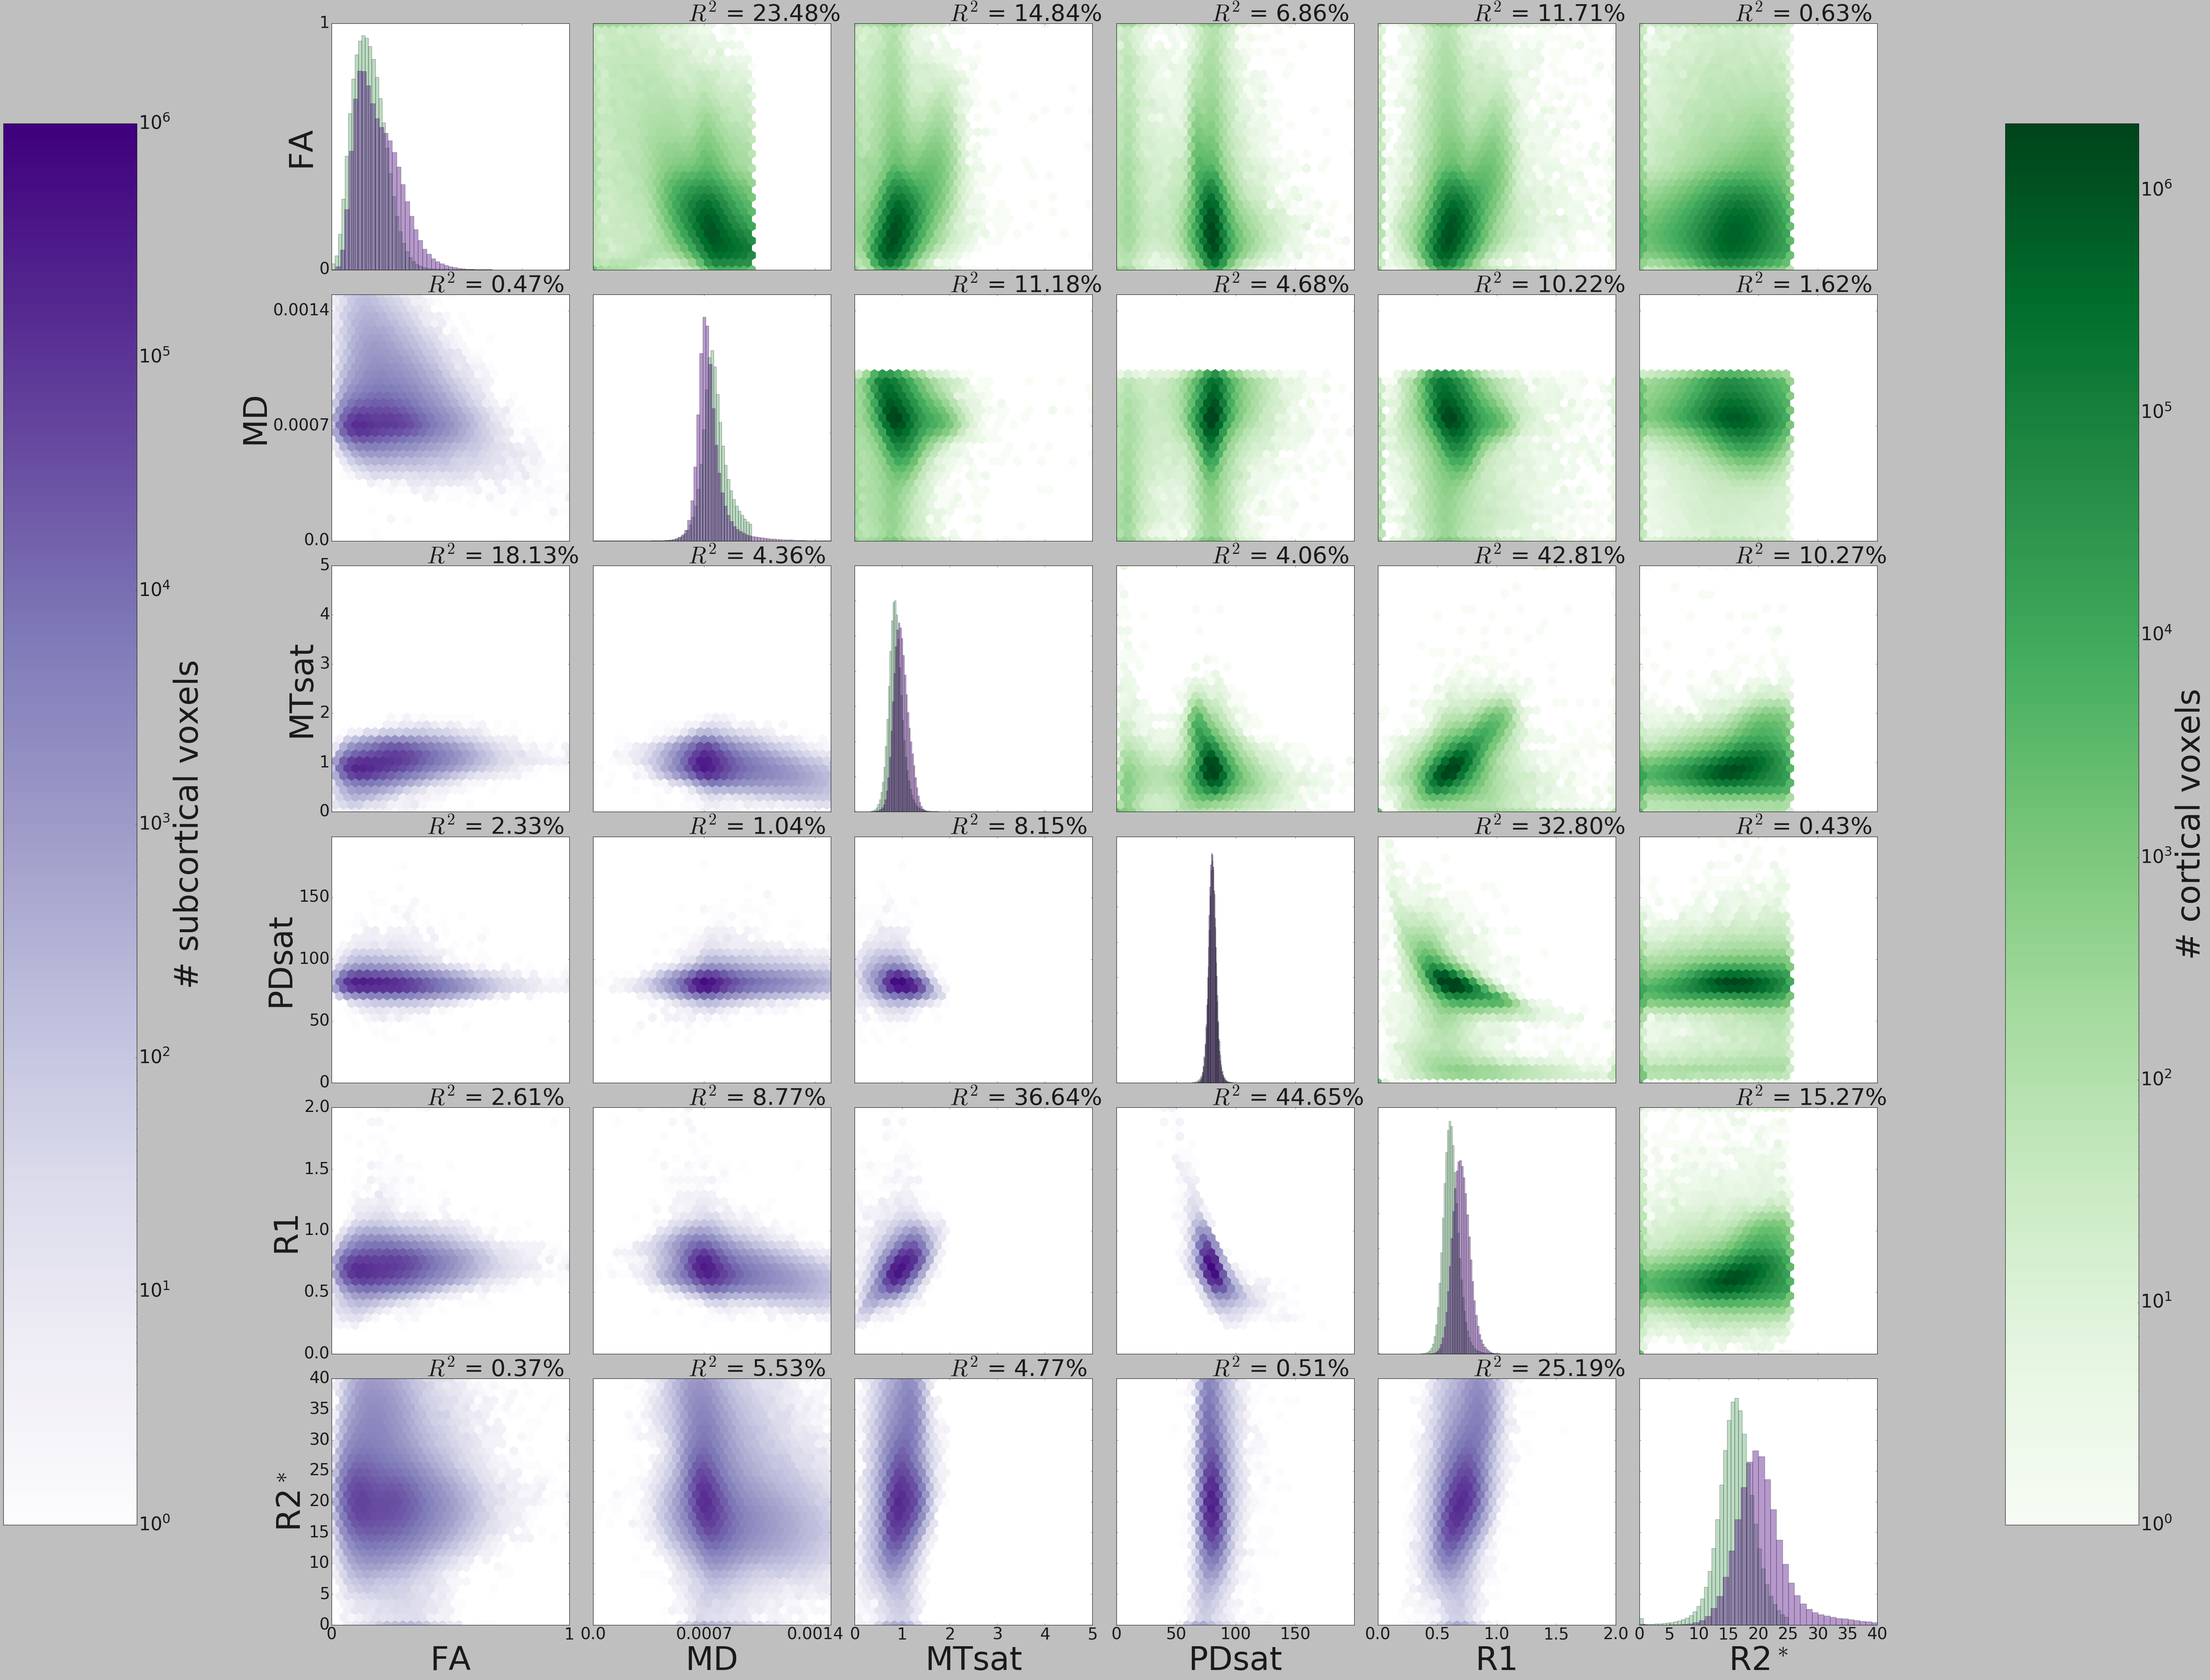

In [39]:
#edit figure from existing data
out_path = '/data/neuralabc/carfra/QuantMetComp/processing/MPM/MPM_correlations/Corticalmasked_vs_subcortical'
    
df_all_cort = pd.read_csv(join(out_path,'cortical_sheath.csv'), index_col=0)
df_all_scort = pd.read_csv(join(out_path,'subcortical_GM.csv'), index_col=0)
for ii in name:
    df_all_cort[ii][df_all_cort[ii]<0] = 0
    df_all_scort[ii][df_all_scort[ii]<0] = 0


fig = plt.figure(figsize=(80,60))
gs = gridspec.GridSpec(nrows=6, 
                       ncols=8, 
                       figure=fig, 
                       width_ratios= [1, 1, 1, 1, 1, 1, 1, 1],
                       height_ratios=[1, 1, 1, 1, 1, 1],
                       wspace=0.1,
                       hspace=0.1)
#     ax1 = fig.add_subplot(gs[:, 0])
#     ax2 = fig.add_subplot(gs[:, -1]) 


for xx in range(6):
    for yy in range(6):
        if max_val[xx] != None:
            max_x = max_val[xx]
        else:
            max_x = max(df_all_cort.max()[df_all_cort.columns[xx]],df_all_scort.max()[df_all_cort.columns[xx]])
        if max_val[yy] != None:
            max_y = max_val[yy]
        else:
            max_y = max(df_all_cort.max()[df_all_cort.columns[yy]],df_all_scort.max()[df_all_cort.columns[yy]]) 

        if xx == yy:
            ax = fig.add_subplot(gs[yy, xx+1])
            cort_bins = (df_all_cort[df_all_cort.columns[xx]].max()-df_all_cort[df_all_cort.columns[xx]].min()) / (8*df_all_cort[df_all_cort.columns[xx]].std())*40
            scort_bins = (df_all_scort[df_all_cort.columns[xx]].max()-df_all_scort[df_all_cort.columns[xx]].min()) / (8*df_all_scort[df_all_cort.columns[xx]].std())*40
            sns.distplot(df_all_cort[df_all_cort.columns[xx]], bins=int(cort_bins), color="g", kde=False, norm_hist =True)
            sns.distplot(df_all_scort[df_all_cort.columns[xx]], bins=int(scort_bins), color="indigo", kde=False, norm_hist =True)
            if xx == 0:
                ax.set_ylim([0,ax.get_yticks()[-1]])
                ax.set_yticks(np.arange(0, ax.get_yticks()[-1]+1, ax.get_yticks()[-1]/5))
                ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
            plt.xlim(0,max_x)

        elif xx>yy:
            ax = fig.add_subplot(gs[yy, xx+1])
            hba = plt.hexbin(df_all_cort[df_all_cort.columns[xx]], 
                            df_all_cort[df_all_cort.columns[yy]], 
                            cmap='Greens',gridsize = 30,mincnt = 1,
                            bins='log',vmax = 10**6.3, 
                            extent=[0,max_x,
                                    0,max_y])
            r, p = stats.pearsonr(df_all_cort[df_all_cort.columns[xx]], df_all_cort[df_all_cort.columns[yy]])
            ax.annotate("$R^2$ = {:.2f}%".format((r**2)*100),
                        xy=(.4, 1.01), xycoords=ax.transAxes, fontsize = 50)
            axx = fig.gca
#                 cb = plt.colorbar(hb)
#                 cb.set_label('log10(N)')


        elif xx<yy:
            ax = fig.add_subplot(gs[yy, xx+1])
            hbb = plt.hexbin(df_all_scort[df_all_cort.columns[xx]], 
                            df_all_scort[df_all_cort.columns[yy]], 
                            cmap='Purples',gridsize = 30,mincnt = 1,
                            bins='log',vmax = 10**6, 
                            extent=[0,max_x,
                                    0,max_y])
            r, p = stats.pearsonr(df_all_scort[df_all_cort.columns[xx]], df_all_scort[df_all_cort.columns[yy]])
            ax.annotate("$R^2$ = {:.2f}%".format((r**2)*100),
                        xy=(.4, 1.01), xycoords=ax.transAxes, fontsize = 50)
            axxx = fig.gca
#                 cb = plt.colorbar(hb)
#                 cb.set_label('log10(N)')


        plt.tick_params(axis='both', which='major', labelsize=35)
        if (xx==1):
            ax.set_xticks(np.arange(0, ax.get_xticks()[-2]+0.000001, ax.get_xticks()[-2]/2))
            labels = ax.get_xticks()
            labels[0] = 0
            ax.set_xticklabels(labels)
        if (yy==1):
            ax.set_yticks(np.arange(0, ax.get_yticks()[-2]+0.000001, ax.get_yticks()[-2]/2))
            labels = ax.get_yticks()
            labels[0] = 0
            ax.set_yticklabels(labels)
        if (xx==0):
            ax.set_xticks(np.array([0,ax.get_xticks()[-2]]))
            ax.set_xticklabels(np.array([0,1]))
        if (yy==0):
            ax.set_yticks(np.array([0,ax.get_yticks()[-1]]))
            ax.set_yticklabels(np.array([0,1]))
        if not (xx==0):
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(name_plt[yy], fontsize=70)
        if not (yy==5):
            ax.set_xticklabels([])
            ax.set_xlabel('')
        else:
            ax.set_xlabel(name_plt[xx], fontsize=70)
            
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(hba, cax=cbar_ax)
cbar.ax.tick_params(labelsize=40)
cbar.set_label('# cortical voxels',fontsize = 70)

cbar_ax = fig.add_axes([0.1, 0.15, 0.05, 0.7])
cbar = fig.colorbar(hbb, cax=cbar_ax)
cbar.ax.tick_params(labelsize=40)
cbar.set_label('# subcortical voxels',fontsize = 70)
fig.savefig(join(out_path,'tot_hexbin_pairgrid3_{}.svg'.format('cort_scort'))) 

# Rsquared std

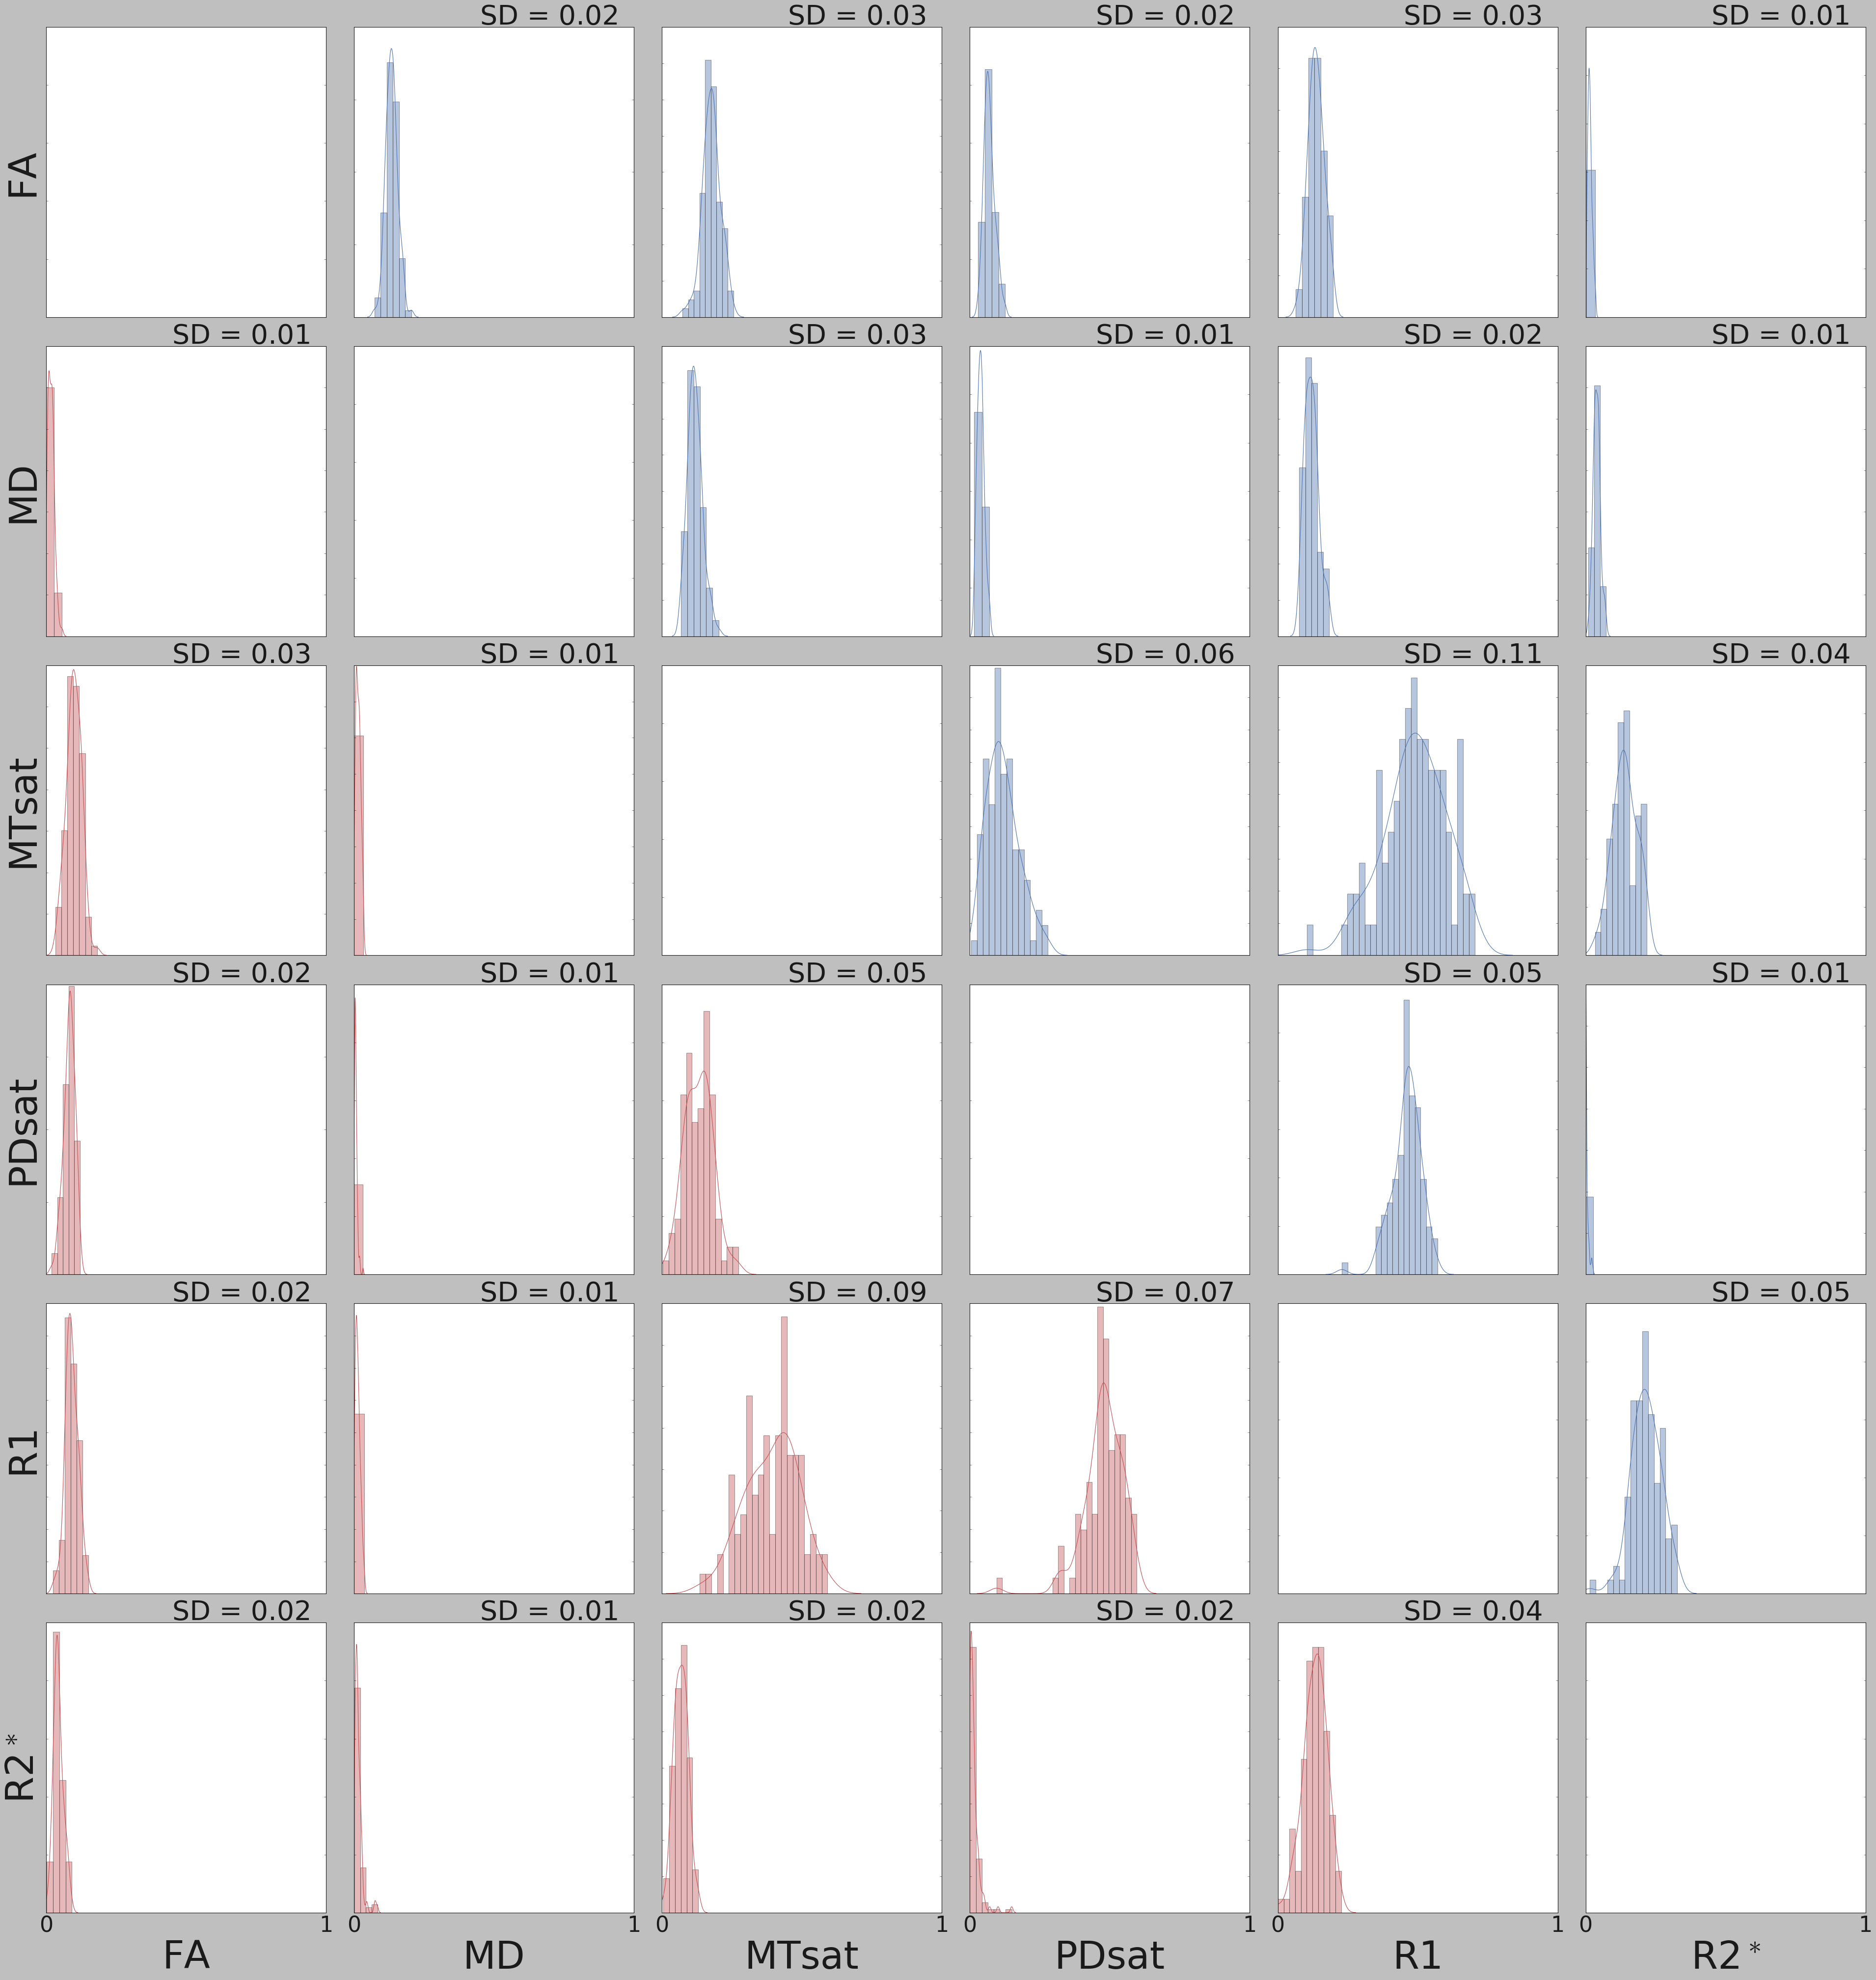

In [47]:
#edit figure from existing data
out_path = '/data/neuralabc/carfra/QuantMetComp/processing/MPM/MPM_correlations/GMmasked_vs_WM2'
    
rsquare = np.load(join(out_path,'rsquares.npy'))

fig = plt.figure(figsize=(80,60))
gs = gridspec.GridSpec(nrows=6, 
                       ncols=8, 
                       figure=fig, 
                       width_ratios= [1, 1, 1, 1, 1, 1, 1, 1],
                       height_ratios=[1, 1, 1, 1, 1, 1],
                       wspace=0.1,
                       hspace=0.1)
#     ax1 = fig.add_subplot(gs[:, 0])
#     ax2 = fig.add_subplot(gs[:, -1]) 


for xx in range(6):
    for yy in range(6):
        if xx == yy:
            xxxx=1
            ax = fig.add_subplot(gs[yy, xx+1])
#             continue
        else:
            ax = fig.add_subplot(gs[yy, xx+1])
            n_bins = (max(rsquare[:,yy,xx])-min(rsquare[:,yy,xx])) / 0.02
            if xx<yy:
                sns.distplot(rsquare[:,yy,xx], bins=int(n_bins), color="r", kde=True, norm_hist =True)
                #color="indigo"   color="r"
            if xx>yy:
                sns.distplot(rsquare[:,yy,xx], bins=int(n_bins), color="b", kde=True, norm_hist =True)
                #color="g", color="b"
            if xx == 0:
                ax.set_yticklabels([])
#                 ax.set_ylim([0,ax.get_yticks()[-1]])
#                 ax.set_yticks(np.arange(0, ax.get_yticks()[-1]+1, ax.get_yticks()[-1]/5))
#                 ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
#             plt.xlim(0,max_x)
            ax.annotate("SD = {:.2f}".format(rsquare[:,yy,xx].std()),
                        xy=(.45, 1.01), xycoords=ax.transAxes, fontsize = 50)
            plt.xlim(0,1)


        plt.tick_params(axis='both', which='major', labelsize=40)
#         if (xx==1):
#             for tick in ax.get_xticklabels():
#                 tick.set_rotation(90)
        ax.set_xticks(np.array([0,1]))
        ax.set_xticklabels(np.array([0,1]))
        if not (xx==0):
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels([])
            ax.set_ylabel(name_plt[yy], fontsize=70)
        if not (yy==5):
            ax.set_xticklabels([])
            ax.set_xlabel('')
        else:
            ax.set_xlabel(name_plt[xx], fontsize=70)
            
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# cbar = fig.colorbar(hba, cax=cbar_ax)
# cbar.ax.tick_params(labelsize=30)
# cbar.set_label('# cortical voxels',fontsize = 70)

# cbar_ax = fig.add_axes([0.1, 0.15, 0.05, 0.7])
# cbar = fig.colorbar(hbb, cax=cbar_ax)
# cbar.ax.tick_params(labelsize=30)
# cbar.set_label('# subcortical voxels',fontsize = 70)
fig.savefig(join(out_path,'rsquared.svg')) 